# Import the package


In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

# Download the data from google drive then unzip the file



In [ ]:
# These commands are only avalible in colab
!nvidia-smi
!gdown --id '1e6s5NT30xmX6nyF3UBV8PTzFkPfLH6VS' --output data.zip
!unzip data.zip

# If you use jpyter notebook please use the following codes

# os.system("nvidia-smi")
# os.system("gdown --id '1e6s5NT30xmX6nyF3UBV8PTzFkPfLH6VS' --output data.zip")
# os.system("unzip data.zip")



串流輸出內容已截斷至最後 5000 行。
  inflating: data_3classes/train/0/01711_Mask.jpg_0.jpeg  
  inflating: data_3classes/train/0/01522_Mask.jpg_0.jpeg  
  inflating: data_3classes/train/0/augmented_image_86.jpg_0.jpeg  
  inflating: data_3classes/train/0/01493_Mask.jpg_0.jpeg  
  inflating: data_3classes/train/0/01808_Mask.jpg_0.jpeg  
  inflating: data_3classes/train/0/augmented_image_206.jpg_0.jpeg  
  inflating: data_3classes/train/0/01525_Mask.jpg_0.jpeg  
  inflating: data_3classes/train/0/augmented_image_82.jpg_0.jpeg  
  inflating: data_3classes/train/0/augmented_image_124.jpg_0.jpeg  
  inflating: data_3classes/train/0/01528_Mask.jpg_0.jpeg  
  inflating: data_3classes/train/0/01756_Mask.jpg_0.jpeg  
  inflating: data_3classes/train/0/01761_Mask.jpg_0.jpeg  
  inflating: data_3classes/train/0/augmented_image_129.jpg_0.jpeg  
  inflating: data_3classes/train/0/01796_Mask.jpg_0.jpeg  
  inflating: data_3classes/train/0/augmented_image_277.jpg_0.jpeg  
  inflating: data_3classes/train/0/01635_M

# Define the model
###Here we constract a traditional VGG-like model as the mask classifier for our task.

###Here I didn't use Batchnorm layer to normalize weights in each layer, since the network I use here only has three layers, while Batchnorm is more effective in the deeper network. 
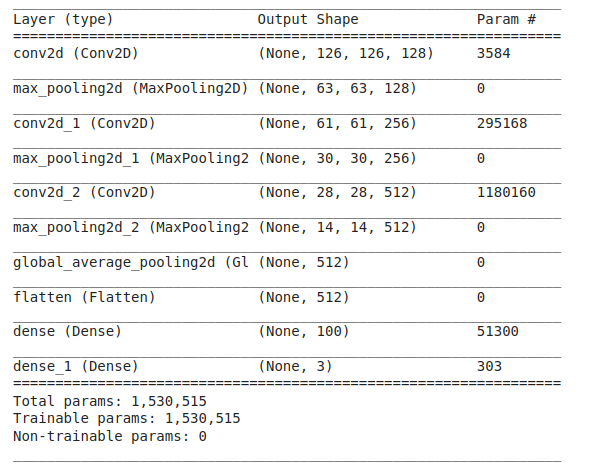

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])



model.summary()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 512)       0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0

# Load the trainings sets and validation sets
###Use ImageDataGenerator to apply data augmentation on the training sets.
###Here I use seven methods


1.   rescale: Normalize the input pixel fromm [0,255] to [0,1]
2.   rotation_range: Randomly rotate the image

1.   width_shift_range&height_shift_range: Randomly shift image 
2.   shear_range: Randomly shear the image 

1.   zoom_range: Randomly zoom the image
2.   horizontal_flip: Randomly flip the image along y axis

If you want to check more augmentation method, click the link here [link text](https://keras.io/api/preprocessing/image/)
















In [ ]:
TRAINING_DIR = "data_3classes/train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   fill_mode='nearest')





train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                           batch_size=64, 
                           target_size=(128, 128),
                           shuffle=True)

print(train_generator)

VALIDATION_DIR = "data_3classes/validation"
validation_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                batch_size=128, 
                                target_size=(128, 128),
                                shuffle=True)
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 4352 images belonging to 3 classes.
Found 838 images belonging to 3 classes.


# Fit the data and labels

In [ ]:
history = model.fit_generator(train_generator,
                              epochs=60,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
68/68 [==============================] - 76s 997ms/step - loss: 0.4645 - acc: 0.8504 - val_loss: 4.4146 - val_acc: 0.4069
INFO:tensorflow:Assets written to: model-001.model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/60
68/68 [==============================] - 64s 939ms/step - loss: 0.2476 - acc: 0.9141 - val_loss: 2.3806 - val_acc: 0.4033
INFO:tensorflow:Assets written to: model-002.model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/60
68/68 [==============================] - 64s 932ms/step - loss: 0.2095 - acc: 0.9226 - val_loss: 0.4817 - val_acc: 0.8437
INFO:tensorflow:Assets written to: model-003.model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/60
68/68 [==============================] - 64s 930ms/step - loss: 0.1715 - acc: 0.9407 - val_loss: 0.8331 - val_acc: 0.8461
Epoch 5/60
68/68 [==============================] - 64s 934ms/step - loss: 0.1953 - acc: 0.9301 - val_loss: 1.1443 - val_acc: 0.6814
Epoch 6/60
68/68 [==============================] - 64s 935ms/step - loss: 0.1518 - acc: 0.9449 - val_loss: 0.3835 - val_acc: 0.8711
INFO:tensorflow:Assets written to: model-006.model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/60
68/68 [==============================] - 64s 930ms/step - loss: 0.1356 - acc: 0.9501 - val_loss: 0.2180 - val_acc: 0.9224
INFO:tensorflow:Assets written to: model-007.model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/60
68/68 [==============================] - 64s 943ms/step - loss: 0.1489 - acc: 0.9451 - val_loss: 1.2164 - val_acc: 0.7936
Epoch 9/60
68/68 [==============================] - 65s 945ms/step - loss: 0.1385 - acc: 0.9515 - val_loss: 15.1435 - val_acc: 0.3437
Epoch 10/60
68/68 [==============================] - 64s 939ms/step - loss: 0.1174 - acc: 0.9609 - val_loss: 0.3815 - val_acc: 0.8699
Epoch 11/60
68/68 [==============================] - 64s 941ms/step - loss: 0.1371 - acc: 0.9515 - val_loss: 0.3370 - val_acc: 0.8998
Epoch 12/60
68/68 [==============================] - 64s 938ms/step - loss: 0.1288 - acc: 0.9557 - val_loss: 0.5645 - val_acc: 0.8580
Epoch 13/60
68/68 [==============================] - 64s 939ms/step - loss: 0.1202 - acc: 0.9554 - val_loss: 1.8679 - val_acc: 0.7172
Epoch 14/60
68/68 [==============================] - 64s 940ms/step - loss: 0.1250 - acc: 0.9563 - val_loss: 0.3486 - val_acc: 0.8998
Epoch 15/60
68/68 [==============================] - 64s 940ms/

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/60
68/68 [==============================] - 65s 952ms/step - loss: 0.0904 - acc: 0.9671 - val_loss: 0.1517 - val_acc: 0.9463
INFO:tensorflow:Assets written to: model-016.model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/60
68/68 [==============================] - 65s 944ms/step - loss: 0.0913 - acc: 0.9655 - val_loss: 0.5788 - val_acc: 0.8556
Epoch 18/60
68/68 [==============================] - 64s 938ms/step - loss: 0.0914 - acc: 0.9699 - val_loss: 0.2460 - val_acc: 0.9212
Epoch 19/60
68/68 [==============================] - 64s 940ms/step - loss: 0.1103 - acc: 0.9596 - val_loss: 0.5023 - val_acc: 0.8771
Epoch 20/60
68/68 [==============================] - 64s 942ms/step - loss: 0.1012 - acc: 0.9637 - val_loss: 0.2386 - val_acc: 0.9356
Epoch 21/60
68/68 [==============================] - 64s 943ms/step - loss: 0.1063 - acc: 0.9623 - val_loss: 0.5584 - val_acc: 0.7876
Epoch 22/60
68/68 [==============================] - 64s 943ms/step - loss: 0.0874 - acc: 0.9692 - val_loss: 0.1608 - val_acc: 0.9523
Epoch 23/60
68/68 [==============================] - 64s 939ms/step - loss: 0.1022 - acc: 0.9671 - val_loss: 0.1843 - val_acc: 0.9344
Epoch 24/60
68/68 [==============================] - 65s 944ms

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 37/60
68/68 [==============================] - 64s 934ms/step - loss: 0.0758 - acc: 0.9720 - val_loss: 0.1293 - val_acc: 0.9463
INFO:tensorflow:Assets written to: model-037.model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 38/60
68/68 [==============================] - 64s 938ms/step - loss: 0.0842 - acc: 0.9688 - val_loss: 1.4193 - val_acc: 0.6897
Epoch 39/60
68/68 [==============================] - 64s 934ms/step - loss: 0.0695 - acc: 0.9743 - val_loss: 0.6598 - val_acc: 0.8723
Epoch 40/60
68/68 [==============================] - 64s 935ms/step - loss: 0.0822 - acc: 0.9667 - val_loss: 0.3326 - val_acc: 0.9021
Epoch 41/60
68/68 [==============================] - 64s 937ms/step - loss: 0.0753 - acc: 0.9729 - val_loss: 0.1583 - val_acc: 0.9535
Epoch 42/60
68/68 [==============================] - 64s 932ms/step - loss: 0.0598 - acc: 0.9809 - val_loss: 0.2204 - val_acc: 0.9260
Epoch 43/60
68/68 [==============================] - 64s 933ms/step - loss: 0.0635 - acc: 0.9777 - val_loss: 0.3513 - val_acc: 0.8747
Epoch 44/60
68/68 [==============================] - 64s 930ms/step - loss: 0.0628 - acc: 0.9766 - val_loss: 0.5055 - val_acc: 0.8771
Epoch 45/60
68/68 [==============================] - 64s 934ms

In [ ]:
!mkdir "tflite_models"
!zip -r model model-023.model/*

BEST_MODEL = "model-029.model"
tflite_model = hub.load(BEST_MODEL)
TFLITE_QUANT_MODEL = "tflite_models/model.tflite"


run_model = tf.function(lambda x : tflite_model(x))

# Save the concrete function.

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec((1,128,128,3), model.inputs[0].dtype)
)

# converter = tf.lite.TFLiteConverter.from_keras_model("savePath")
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

# Save the model
with open(TFLITE_QUANT_MODEL, 'wb') as f:
    f.write(tflite_quant_model)


	zip warning: name not matched: model-023.model/*

zip error: Nothing to do! (try: zip -r model . -i model-023.model/*)
